In [1]:
import numpy as np
import os, cv2
import h5py
import tifffile
from tqdm import tqdm, trange
from deepreg.predict import unwrapped_predict, normalize_batched_image
from deepreg.model.layer import Warping
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image


batch_size = 1
label_shape = (30, 3)

2025-03-14 14:14:34.772243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 14:14:34.772290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 14:14:34.773604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Register two frames

In [10]:
# tiff_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/1255_psuudo_Composite.tif"
tiff_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/7981_pseudo_Composite.tif"


# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_again/save/ckpt-626"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/both_datasets_mixed_dp_rot/save/ckpt-999"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_redo_DP/save/ckpt-396"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_redo_DP_real/save/ckpt-368"
checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/weights_shifted/save/ckpt-48"
checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/weights_shifted/save/ckpt-359"
checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/weights_shifted_2/save/ckpt-385"
# output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/no_align.mp4"
log_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/logs"

inputs = tifffile.imread(tiff_path)
image1 = inputs[0]
rois1 = inputs[1]

print(inputs.shape)

(2, 1080, 1080)


In [20]:
# tiff_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/1255_psuudo_Composite.tif"
tiff_path_im = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/7981_pseudo_Composite.tif"
tiff_path_ro = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/7981.pseudo.tif"

inputs = tifffile.imread(tiff_path_im)
fixed_image = inputs[0]
inputs = tifffile.imread(tiff_path_ro)
fixed_rois = inputs
# rois1 = inputs[1]

tiff_path_im = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/1255_pseudo_Composite.tif"
tiff_path_ro = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/1255.pseudo.tif"

inputs = tifffile.imread(tiff_path_im)
moving_image = inputs[0]
inputs = tifffile.imread(tiff_path_ro)
moving_rois = inputs

print(inputs.shape)

(1080, 1080)


In [ ]:
# h5_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/10535_pseudo_Composite.h5"

# with h5py.File(h5_path, 'r') as f:
#     fixed_image = f["t00000/s00/0/cells"][0]
#     fixed_rois = f["t00000/s01/0/cells"][0]

# h5_path_1 = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/7981_pseudo_Composite.h5"

# with h5py.File(h5_path_1, 'r') as f:
#     # moving_image = f["t00000/s00/0/cells"]
#     # moving_image = np.array(moving_image)
#     # moving_image = image1
#     moving_image = f["t00000/s00/0/cells"][0]
#     moving_rois = f["t00000/s01/0/cells"][0]


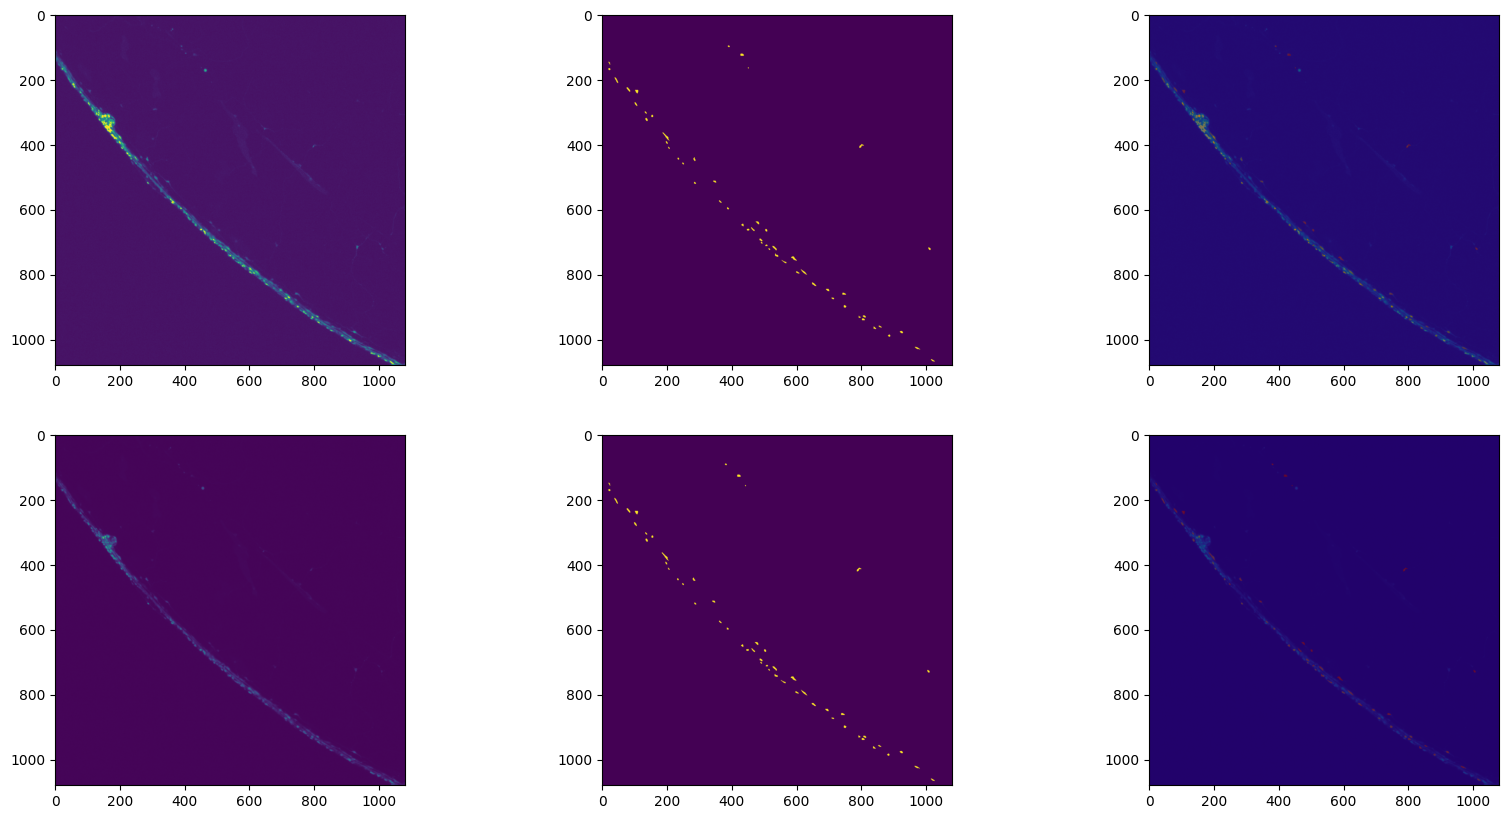

In [21]:
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axes[0, 0].imshow(fixed_image)
axes[0, 1].imshow(fixed_rois)

axes[0, 2].imshow(fixed_image)
axes[0, 2].imshow(fixed_rois, cmap='jet', alpha=0.5)

axes[1, 0].imshow(moving_image)
axes[1, 1].imshow(moving_rois)
axes[1, 2].imshow(moving_image)
axes[1, 2].imshow(moving_rois, cmap='jet', alpha=0.5)


In [22]:
os.chdir("/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/scripts")
from register import set_GPU, register
set_GPU(2)

In [ ]:
#### FIRST WE'RE GOING TO JUST TRY TO ALIGN TO A SINGLE FRAME
## The first batch of good videos was aligned using ckpt-90, going to switch to 626

# output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/first_frame_align.mp4"
output_h5_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/out.h5"
log_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/logs"

config_path = os.path.join(checkpoint_path.split("/save")[0], "config.yaml")
model = None

max_frames = 2000
side_len = 1080
# side_len = 1024
z_size = 3

padding = np.array([[0,0],[0,0],[0,0],[1,1]])

end_size = np.array((side_len, side_len))
start = (fixed_image.shape - end_size)/2 

assert np.all(start == start.astype(int)), f"Invalid Crop Size ({end_size}) for the Provided Image Size ({fixed_image.shape})"
start = start.astype(int)

fixed_image_crop = fixed_image[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1]]
moving_image_crop = moving_image[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1]]
moving_rois_crop = moving_rois[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1]]


# Colorize
shape = moving_rois_crop.shape
size = shape[0] * shape[1]
blank = np.arange(size).reshape(shape)
# plt.imshow(mask)

blank =  blank * (moving_rois_crop > 0)

prev = np.array(0)
while np.any(prev != blank):
    prev = blank
    blank = maximum_filter(blank, size=3, mode='constant')
    blank = blank * mask


batched_fixed_image = np.pad(fixed_image_crop[np.newaxis, ..., np.newaxis], padding, "constant", constant_values=0).astype(np.float32)

warping_linear = Warping(fixed_image_size=(side_len, side_len, z_size), batch_size=batch_size)
warping_nearest = Warping(fixed_image_size=(side_len, side_len, z_size), batch_size=batch_size, interpolation="nearest")



batched_moving_image = np.pad(moving_image_crop[np.newaxis, ..., np.newaxis], padding, "constant", constant_values=0).astype(np.float32)
batched_moving_rois = np.pad(moving_rois_crop[np.newaxis, ..., np.newaxis], padding, "constant", constant_values=0).astype(np.float32)
# batched_moving_rois[batched_moving_rois > 0] = 1


ddf_output, pred_fixed_image, model = unwrapped_predict(
    batched_fixed_image,
    batched_moving_image,
    log_dir,
    label_shape,
    label_shape,
    model = model,
    model_ckpt_path = checkpoint_path,
    model_config_path = config_path,
)

# gr_in = np.pad(green_in[(frame - offset):(frame - offset)+batch_size, ..., np.newaxis], padding, "constant", constant_values=0).astype(np.float32)
# outs[frame - offset:(frame - offset) + batch_size] = warping(inputs=[ddf_output, gr_in]).numpy()[..., 1]

warped_rois_lin = warping_linear(inputs=[ddf_output, batched_moving_rois]).numpy()[0,..., 1]
warped_rois_ne = warping_nearest(inputs=[ddf_output, batched_moving_rois]).numpy()[0,..., 1]
warped_rois = warped_rois_ne

with h5py.File(output_h5_path, 'w') as f:
    f.create_dataset("fixed_image", data=fixed_image)
    f.create_dataset("fixed_rois", data=fixed_rois)
    f.create_dataset("moving_image", data=moving_image)
    f.create_dataset("moving_rois", data=moving_rois)
    f.create_dataset("warped_image", data=pred_fixed_image[0,...,1])
    f.create_dataset("warped_rois-LinearInterpolation", data=warped_rois_lin)
    f.create_dataset("warped_rois-NearestInterpolation", data=warped_rois)
    f.create_dataset("ddf", data=ddf_output)


2025-03-14 14:18:21 | WARNING  | Log directory /home/brian/data4/brian/PBnJ/jelly_h5s/psuedo_colored/logs exists already.
2025-03-14 14:18:21 | WARNING  | Using customized configuration. The code might break if the config doesn't match the saved model.
Built inputs.
Built control points.
Concatenated images.
{'extract_levels': ListWrapper([0, 1, 2, 3]), 'name': 'local', 'num_channel_initial': 16}
Built backbone.
Built DDF.
Built warping.


In [24]:
fixed_rois_crop = fixed_rois[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1]]


In [25]:
# warped_rois = warped_rois_ne
# warped_rois_ne= warped_rois
warped_rois = warped_rois_lin

### Compare Images

In [26]:
print(np.mean(fixed_rois_crop == moving_rois_crop))
print(np.mean((fixed_rois_crop > 0) == (moving_rois_crop > 0)))
print(np.mean(((fixed_rois_crop > 0) == (moving_rois_crop > 0)) & (fixed_rois_crop > 0)))
print(np.sum(((fixed_rois_crop > 0) & (moving_rois_crop > 0))) / np.sum(((fixed_rois_crop > 0) | (moving_rois_crop > 0))))
np.sum(((fixed_rois_crop > 0) == (moving_rois_crop > 0)) & (fixed_rois_crop > 0)) / np.sum((fixed_rois_crop > 0))

0.9976328875171467
0.9976328875171467
0.0008607681755829903
0.26666666666666666


0.4204355108877722

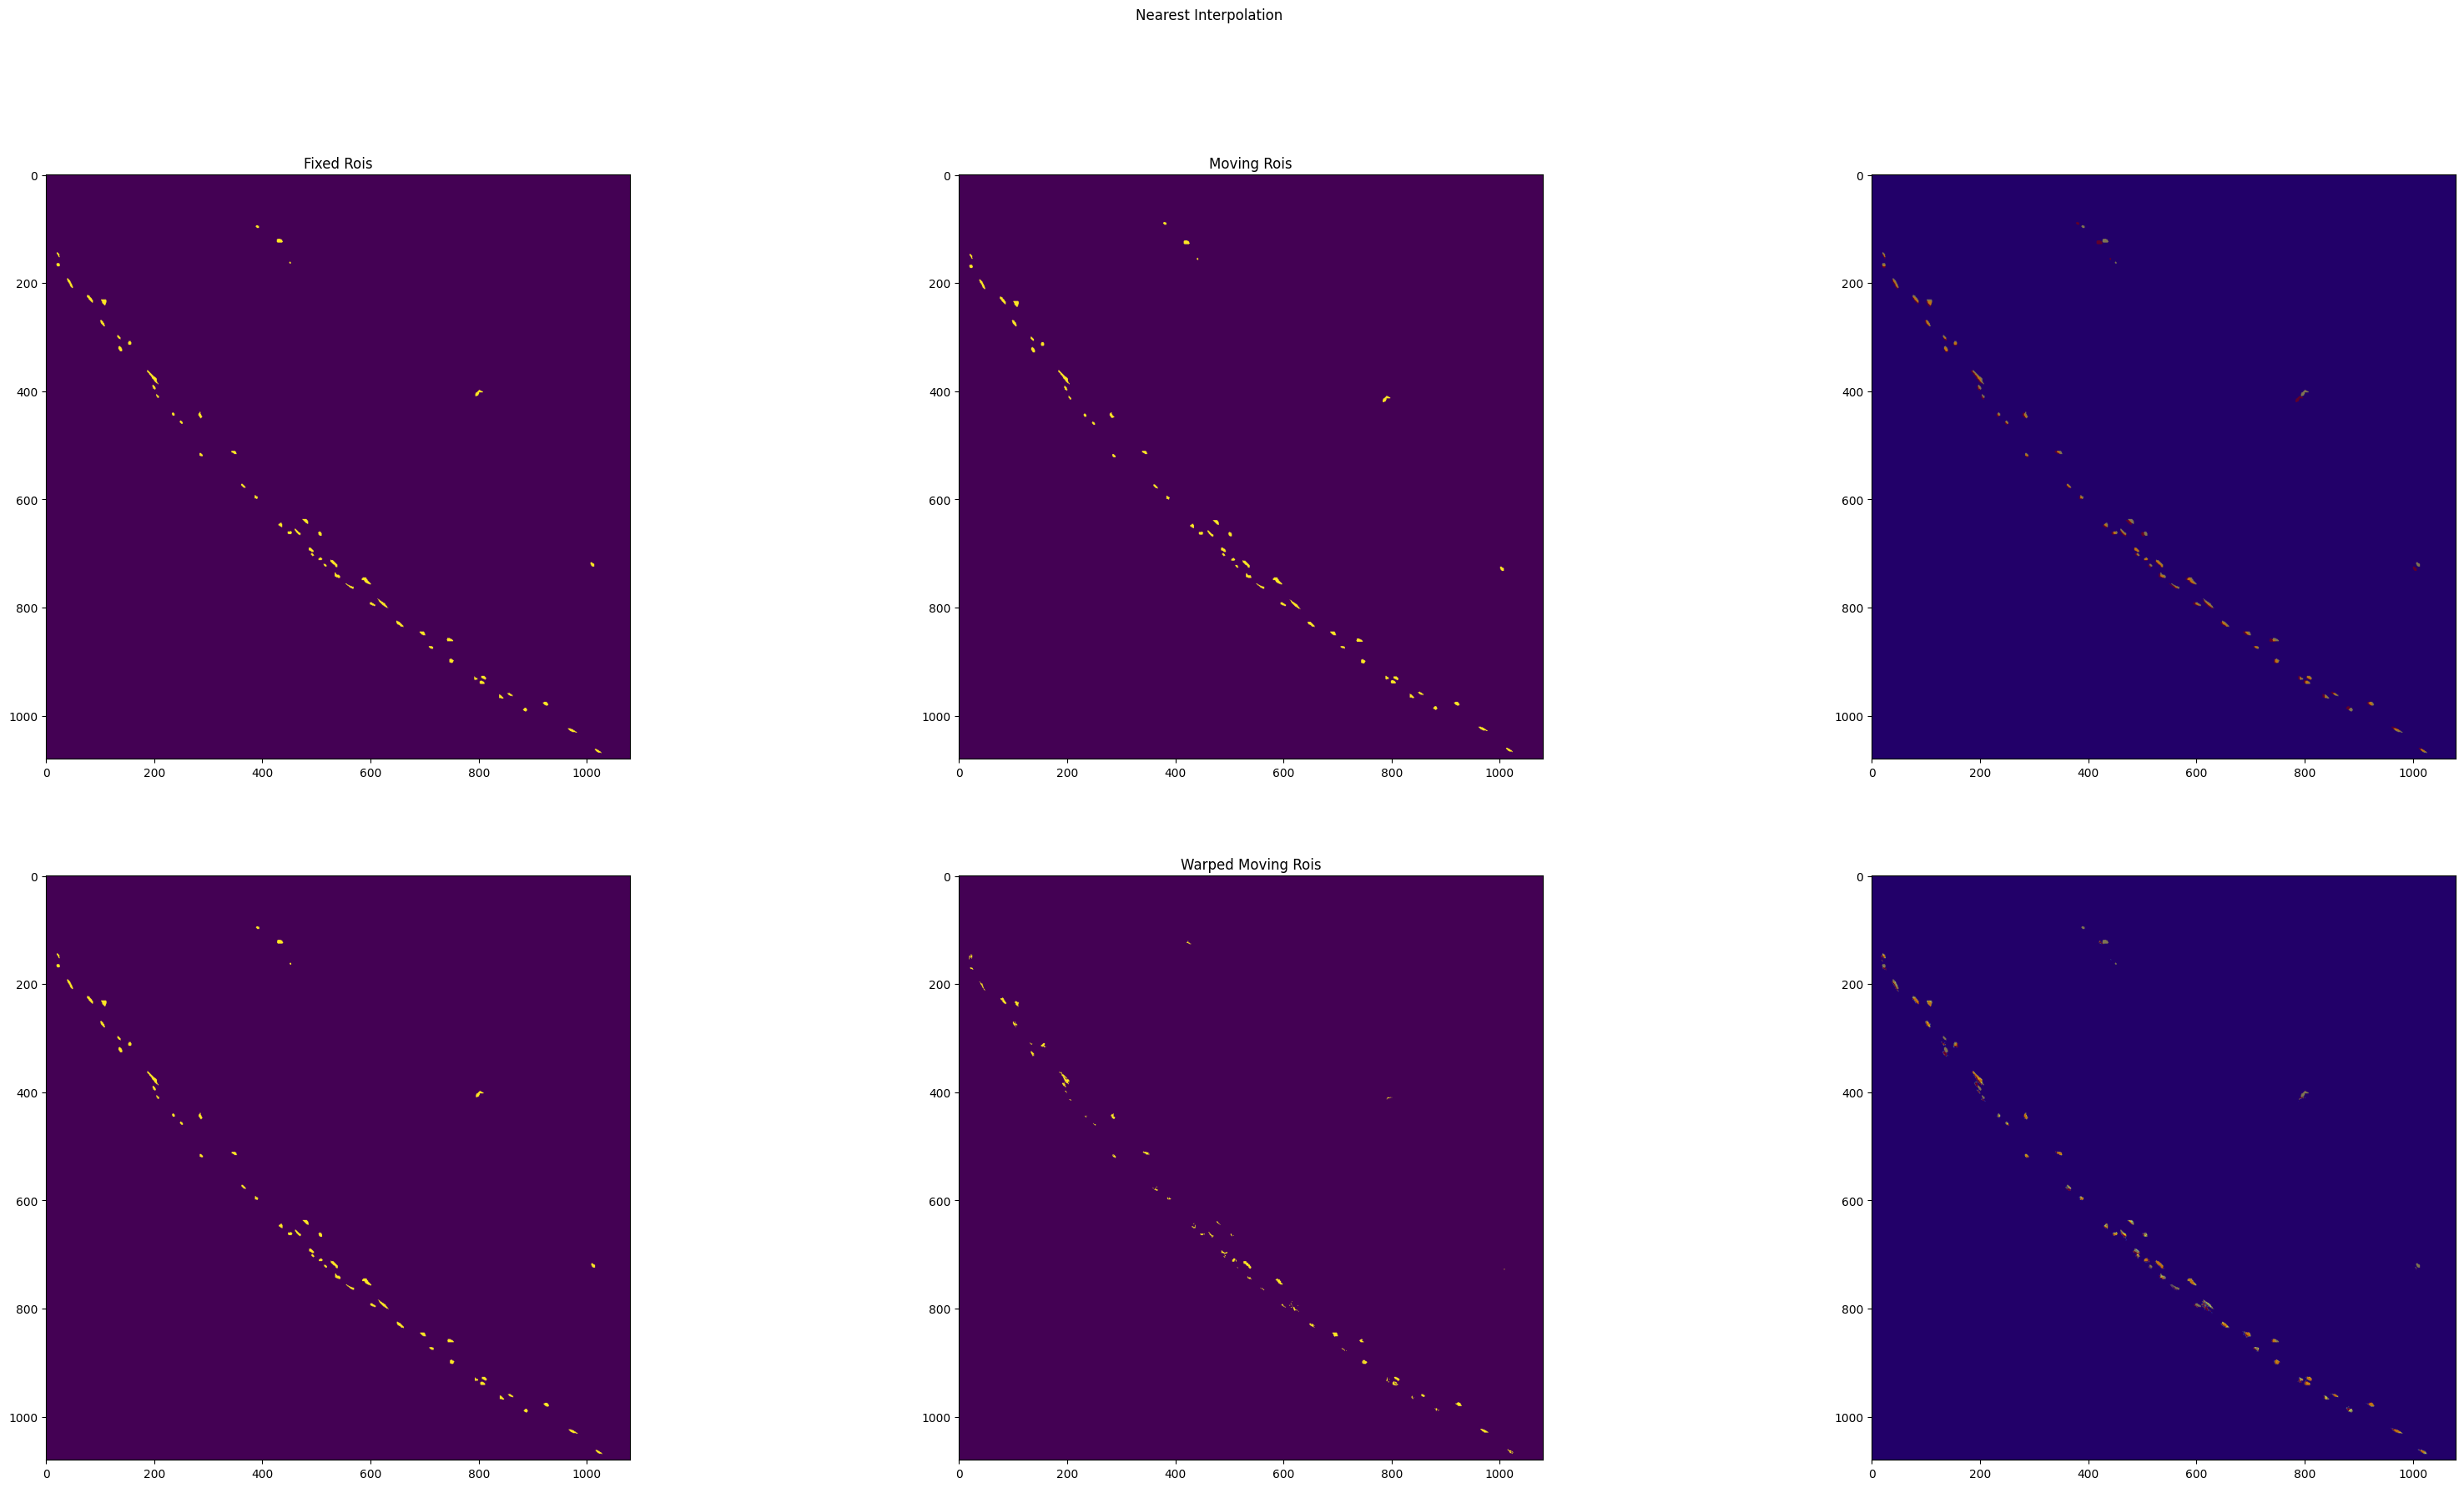

In [27]:
fig, axes = plt.subplots(2,3, figsize=(40, 20))
fig.suptitle("Nearest Interpolation")
axes[0,0].imshow(fixed_rois_crop)
axes[0,0].set_title("Fixed Rois")
axes[0,1].imshow(moving_rois_crop)
axes[0,1].set_title("Moving Rois")


axes[0,2].imshow(fixed_rois_crop)
axes[0,2].imshow(moving_rois_crop, cmap='jet', alpha=0.5)


axes[1,0].imshow(fixed_rois_crop)
# axes[1,1].imshow(warped_rois > 0)
axes[1,1].imshow(warped_rois_lin == np.max(warped_rois_lin))
axes[1,1].set_title("Warped Moving Rois")


axes[1,2].imshow(fixed_rois_crop)
axes[1,2].imshow(warped_rois, cmap='jet', alpha=0.5)

In [12]:
print(np.mean(fixed_rois_crop == warped_rois))
print(np.mean((fixed_rois_crop > 0) == (warped_rois > 0)))
print(np.mean(((fixed_rois_crop > 0) == (warped_rois > 0)) & (fixed_rois_crop > 0)))
print(np.sum(((fixed_rois_crop > 0) & (warped_rois > 0))) / np.sum(((fixed_rois_crop > 0) | (warped_rois > 0))))
print(np.sum(((fixed_rois_crop > 0) & (warped_rois_lin == np.max(warped_rois_lin)))) / np.sum(((fixed_rois_crop > 0) | (warped_rois_lin == np.max(warped_rois_lin)))))
print(f"Proportion of pixels that were ROIs has changed by {(np.sum(warped_rois_ne > 0) / warped_rois_ne.size) / (np.sum(moving_rois_crop > 0) / moving_rois_crop.size)}")
print(f"Proportion of pixels that were ROIs has changed by {(np.sum(warped_rois_lin == np.max(warped_rois_lin)) / warped_rois.size) / (np.sum(moving_rois_crop > 0) / moving_rois_crop.size)}")
np.sum(((fixed_rois_crop > 0) == (warped_rois > 0)) & (fixed_rois_crop > 0)) / np.sum((fixed_rois_crop > 0))


0.9959987997256515
0.9969050068587105
0.0012645747599451303
0.29006882989183874
0.1400804289544236
Proportion of pixels that were ROIs has changed by 0.9782244556113903
Proportion of pixels that were ROIs has changed by 0.4275544388609715


0.6194876102477951

In [ ]:
# fig, axes = plt.subplots(0,2, figsize=(20, 10))
# axes[0].imshow(moving_rois)
# axes[1].imshow(warped_rois)
# warped_rois_ne = warping_nearest(inputs=[ddf_output, batched_moving_rois]).numpy()[0,..., 1]